In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
df = pd.read_csv( "../Training.csv" )
df

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.00,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.00,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.60,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.50,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.50,USD,13357192.5,Closed Lost,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,8781,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16943,8786,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q2,2016,NaT,0,EUR,93015.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16944,8792,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16945,28561,Americas,NE America,1,1,1,1,0,Bureaucratic_Code_4,10/20/2015,...,Q2,2016,NaT,4,USD,2346796.88,USD,0.0,Closed Lost,Prod_Category_A_None


In [3]:
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = df['Total_Amount']*0.0096
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = df['Total_Amount']*1.17
df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = df['Total_Amount']*0.70
df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = df['Total_Amount']*1.29
df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'
df.dropna(inplace = True)
df['Opportunity_Created_Date'] = pd.to_datetime(df['Opportunity_Created_Date'],errors='coerce')
df["Year Created"] = df["Opportunity_Created_Date"].dt.year
df["Month Created"] =df["Opportunity_Created_Date"].dt.month
df["Expensive"] = np.where(df["Total_Amount"] >= 80000, 1, 0)
df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'],errors='coerce')
df['Planned_Delivery_End_Date'] = pd.to_datetime(df['Planned_Delivery_End_Date'],errors='coerce')
df["Total_Amount"] = np.log2(df["Total_Amount"])
entrenamiento_by_region = df.groupby("Region").agg({"Stage" : "count"})
entrenamiento_by_region.rename(columns = {"Stage" : "Amount of Cases"}, inplace = True)
entrenamiento_won_by_region = df[df["Stage"] == "Closed Won"].groupby("Region").agg({"Stage" : "count"})
entrenamiento_won_by_region.rename(columns = {"Stage" : "Cases won"}, inplace = True)

entrenamiento_won_by_region["percentage"] = (entrenamiento_won_by_region["Cases won"] / entrenamiento_by_region["Amount of Cases"]) * 100
df = df.merge(entrenamiento_won_by_region, on = "Region")
df["Años en entregar"] = df["Delivery_Year"] - df["Year Created"]

/home/thiago/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
short_df = df[['Opportunity_ID',"Delivery_Quarter", "Años en entregar", "Total_Amount",'TRF', "percentage", 'Stage' ]].rename(columns={'Stage': 'Decision'})
short_df = short_df[ (short_df['Decision'] == 'Closed Won') | (short_df['Decision'] == 'Closed Lost') ]
short_df['Decision'] = np.where(short_df['Decision'] == 'Closed Won',1,0)
short_df.set_index('Opportunity_ID', inplace = True)
short_df

,Delivery_Quarter,Años en entregar,Total_Amount,TRF,percentage,Decision
Opportunity_ID,,,,,,
0,Q2,1,22.556646,10,53.049828,0
1,Q1,1,15.784152,0,53.049828,1
19,Q2,1,18.213967,0,53.049828,0
20,Q1,1,16.883687,0,53.049828,1
23,Q1,1,17.937127,0,53.049828,1
...,...,...,...,...,...,...
9821,Q1,1,16.891843,0,27.173913,0
9899,Q4,0,16.052122,0,27.173913,0
9968,Q4,0,16.113004,0,27.173913,0


In [5]:


# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        short_df.drop(columns = 'Decision'),
                                        short_df['Decision'],
                                        random_state = 123
                                    )

# One-hot-encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

#El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres de las columnas. Es interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([encoded_cat, numeric_cols])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10218 entries, 0 to 10217
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Delivery_Quarter_Q1  10218 non-null  float64
 1   Delivery_Quarter_Q2  10218 non-null  float64
 2   Delivery_Quarter_Q3  10218 non-null  float64
 3   Delivery_Quarter_Q4  10218 non-null  float64
 4   Años en entregar     10218 non-null  float64
 5   Total_Amount         10218 non-null  float64
 6   TRF                  10218 non-null  float64
 7   percentage           10218 non-null  float64
dtypes: float64(8)
memory usage: 638.8 KB


<AxesSubplot:>

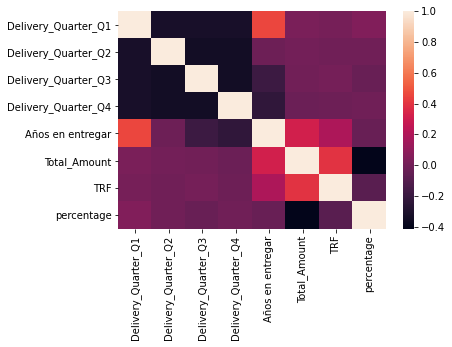

In [6]:
sns.heatmap(X_train_prep.corr())

In [7]:
from lightgbm.sklearn import LGBMRegressor

In [8]:
model = LGBMRegressor(boosting_type = "goss", n_estimators = 1100, learning_rate = 0.008, random_state = 123)

In [9]:
model.fit(X_train_prep, y_train)

LGBMRegressor(boosting_type='goss', learning_rate=0.008, n_estimators=1100,
              random_state=123)

In [10]:
preds = model.predict(X_test_prep)

In [11]:
loss = log_loss(y_test, preds)
loss

0.49937449793865774

In [12]:
val = model.feature_importances_

In [13]:
df = pd.DataFrame(val, index = model.feature_name_)

<AxesSubplot:>

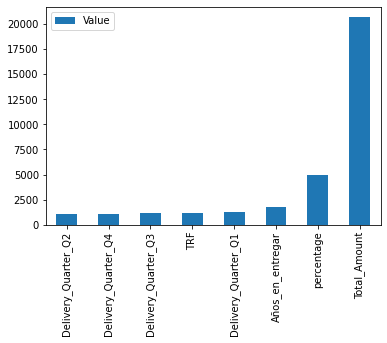

In [14]:
df.columns = ["Value"]
df.sort_values(by = "Value").plot.bar()